# Experimentation notebook

In [250]:
import sys
import torch
sys.path.append('src/fast_ica')
sys.path.append('src/iVAE')

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 3

from tqdm import tqdm
from sklearn.decomposition import FastICA
from torch.utils.data import DataLoader
from torch.optim import Adam, lr_scheduler

from src.iVAE.models import cleanIVAE, cleanVAE
from src.iVAE.data import CustomSyntheticDataset, generate_data
from src.iVAE.metrics import mean_corr_coef as mcc
from src.fast_ica import Fast_ICA

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using cpu device


## Parameters

In [270]:
number_of_points_by_segment = 1000
number_of_segments = 5
dimension_of_latent_space = 2
dimension_of_data_space = 2
seed = 1
prior = 'lap'

simple_mixing = True 
linear_transformation_type="uniform"
activation = 'xtanh' # if simple_mixing is True, activation is not used
slope = 0.1 # if simple_mixing is True, slope is not used
number_of_mixing_layers = 3 # if simple_mixing is True, number_of_mixing_layers is not used
repeat_linearity = False # if simple_mixing is True, repeat_linearity is not used

uncentered = True
centers = np.random.uniform(-5, 5, (number_of_segments, dimension_of_latent_space)) # if uncentered is True, centers is not used

var_bounds = np.array([1, 1])

noisy = 0.1
staircase = False

In [271]:
number_of_simulation = 1
vae_hidden_dim = 100
vae_n_layers = 3
vae_activation = 'xtanh'
vae_slope = 0.1

# Learning rate scheduler params
lr = 0.01
factor = 0.1
patience = 0
verbose = True

epochs = 100

# ELBO weights
a = 100 # reconstruction log-likelihood term
b = 1 #  KL divergence between the approximate posterior an implicit mixture distribution
c = 0 # difference between the log probabilities under the implicit mixture distribution and an importance-sampled approximation
d = 10 # KL divergence between the importance-sampled approximation of the log probabilities under the variational posterior and the prior

## Data

### Generation

In [272]:
source, mixture, segment_labels, mean, variance, mixing_matrix = generate_data(
    n_per_seg=number_of_points_by_segment,
    n_seg=number_of_segments,
    d_sources=dimension_of_latent_space,
    d_data=dimension_of_data_space,
    n_layers=number_of_mixing_layers,
    prior=prior,
    activation=activation,
    seed=seed,
    slope=slope,
    var_bounds=var_bounds,
    lin_type=linear_transformation_type,
    repeat_linearity=repeat_linearity,
    noisy=noisy,
    uncentered=uncentered,
    centers=centers,
    staircase=staircase,
    simple_mixing=simple_mixing,
)
indices = np.argmax(segment_labels, axis=1)


In [273]:
df = pd.concat([
    pd.DataFrame(source, columns=[f"s_{i}" for i in range(source.shape[1])]),
    pd.DataFrame(mixture, columns=[f"x_{i}" for i in range(mixture.shape[1])]),
    pd.DataFrame(indices, columns=["segment"])
], axis=1)

### Visualization

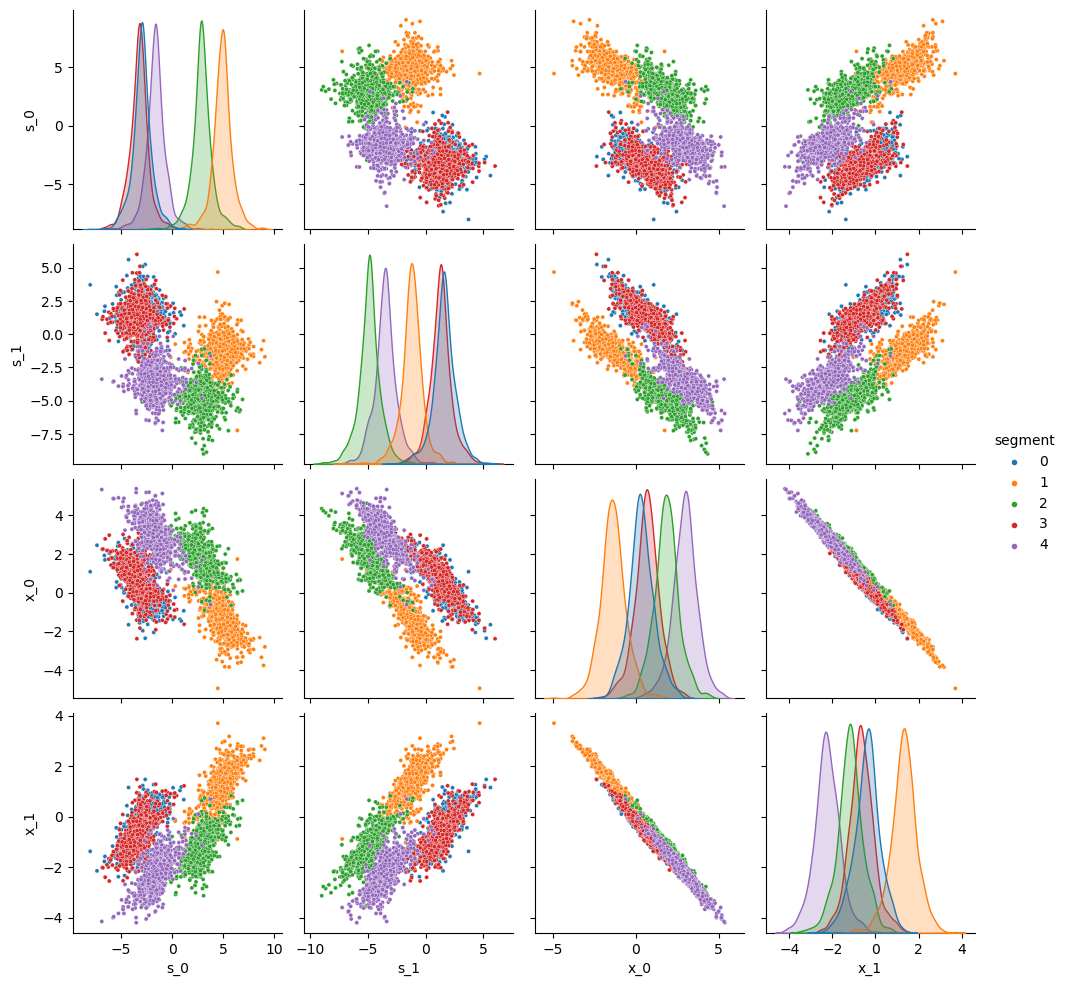

In [274]:
sns.pairplot(df, hue="segment", palette=f"tab10")

Text(0.5, 1.0, 'Original sources')

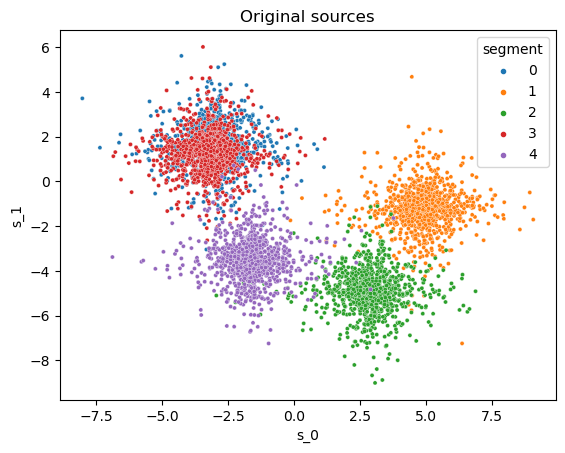

In [275]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Mixed sources')

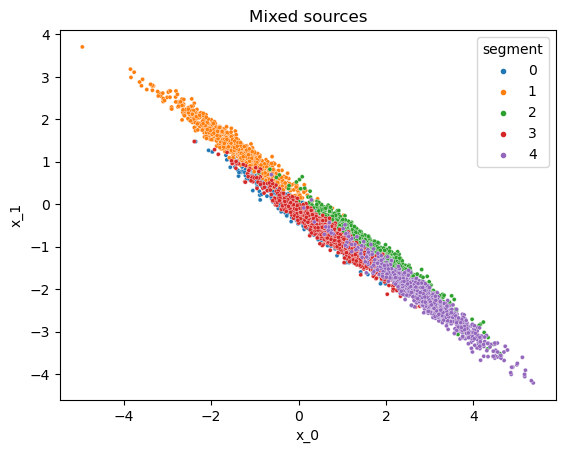

In [276]:
sns.scatterplot(data=df, x="x_0", y="x_1", hue="segment", palette="tab10")
plt.title("Mixed sources")

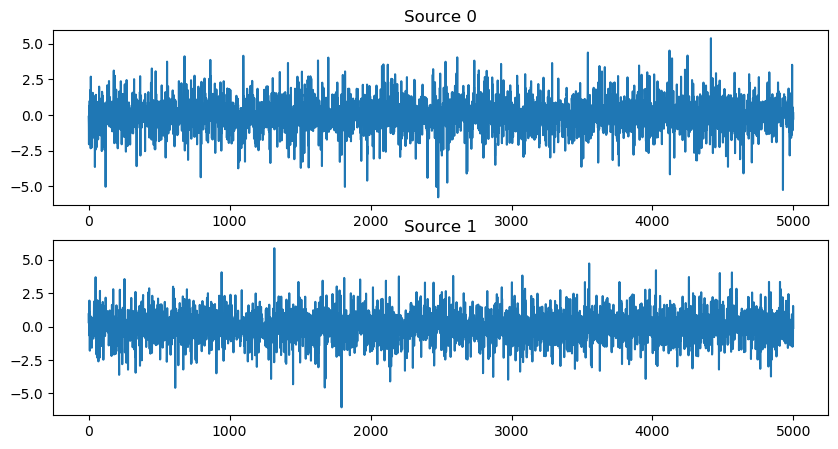

In [221]:
# plot signals
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    axs[i].plot(source[:, i])
    axs[i].set_title(f"Source {i}")

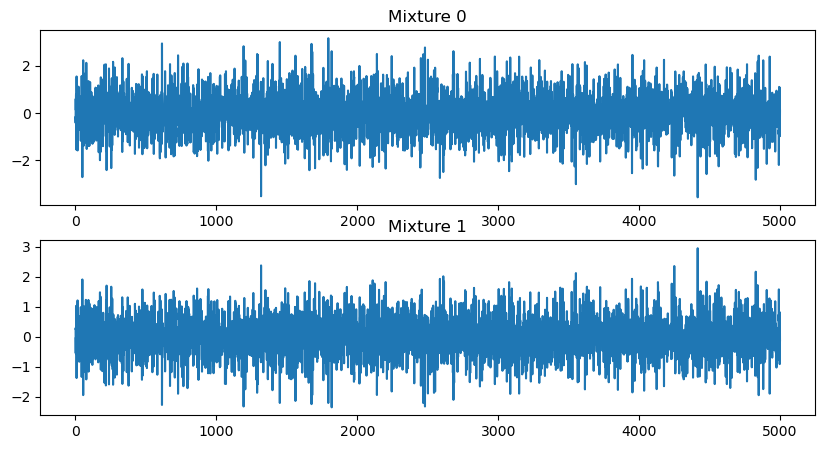

In [222]:
fig, axs = plt.subplots(mixture.shape[1], 1, figsize=(10, 5))
for i in range(mixture.shape[1]):
    axs[i].plot(mixture[:, i])
    axs[i].set_title(f"Mixture {i}")

## FastICA

In [223]:
ica = Fast_ICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=10000)
fast_ica_source_predict = ica.fit_transform(mixture.T, method='parallel').T

In [146]:
ica = FastICA(n_components=dimension_of_latent_space, tol=1e-10, max_iter=10000)

In [147]:
df_fast_ica = pd.concat([
  df,
  pd.DataFrame(fast_ica_source_predict, columns=[f"fast_ica_s_{i}" for i in range(fast_ica_source_predict.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'Original sources')

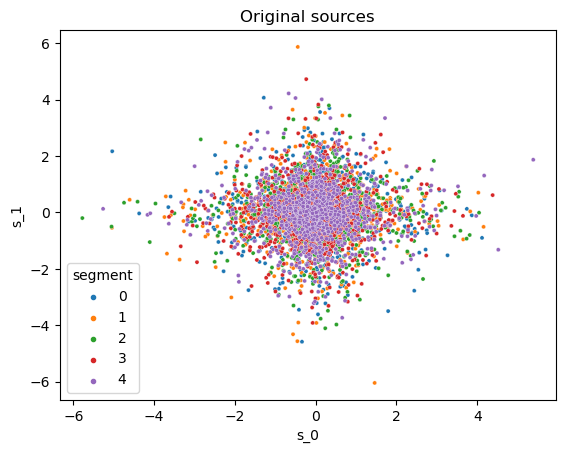

In [224]:
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10")
plt.title("Original sources")

Text(0.5, 1.0, 'Fast ICA recovered sources')

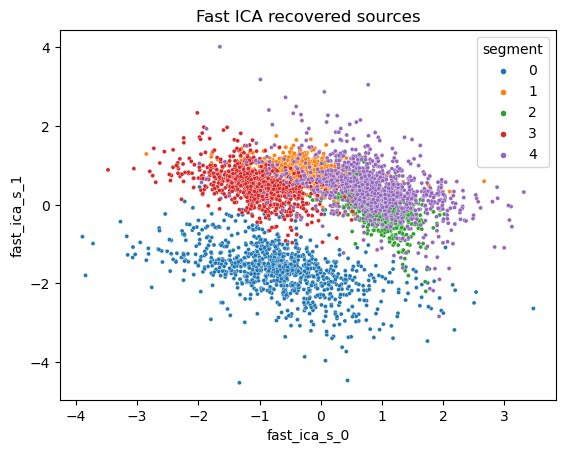

In [225]:
sns.scatterplot(data=df_fast_ica, x="fast_ica_s_0", y="fast_ica_s_1", hue="segment", palette="tab10")
plt.title("Fast ICA recovered sources")

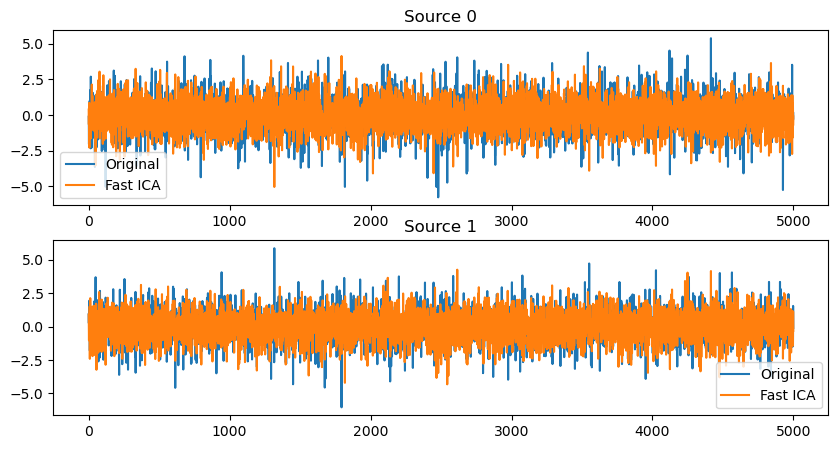

In [226]:
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    axs[i].plot(source[:, i], label="Original")
    axs[i].plot(fast_ica_source_predict[:, i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

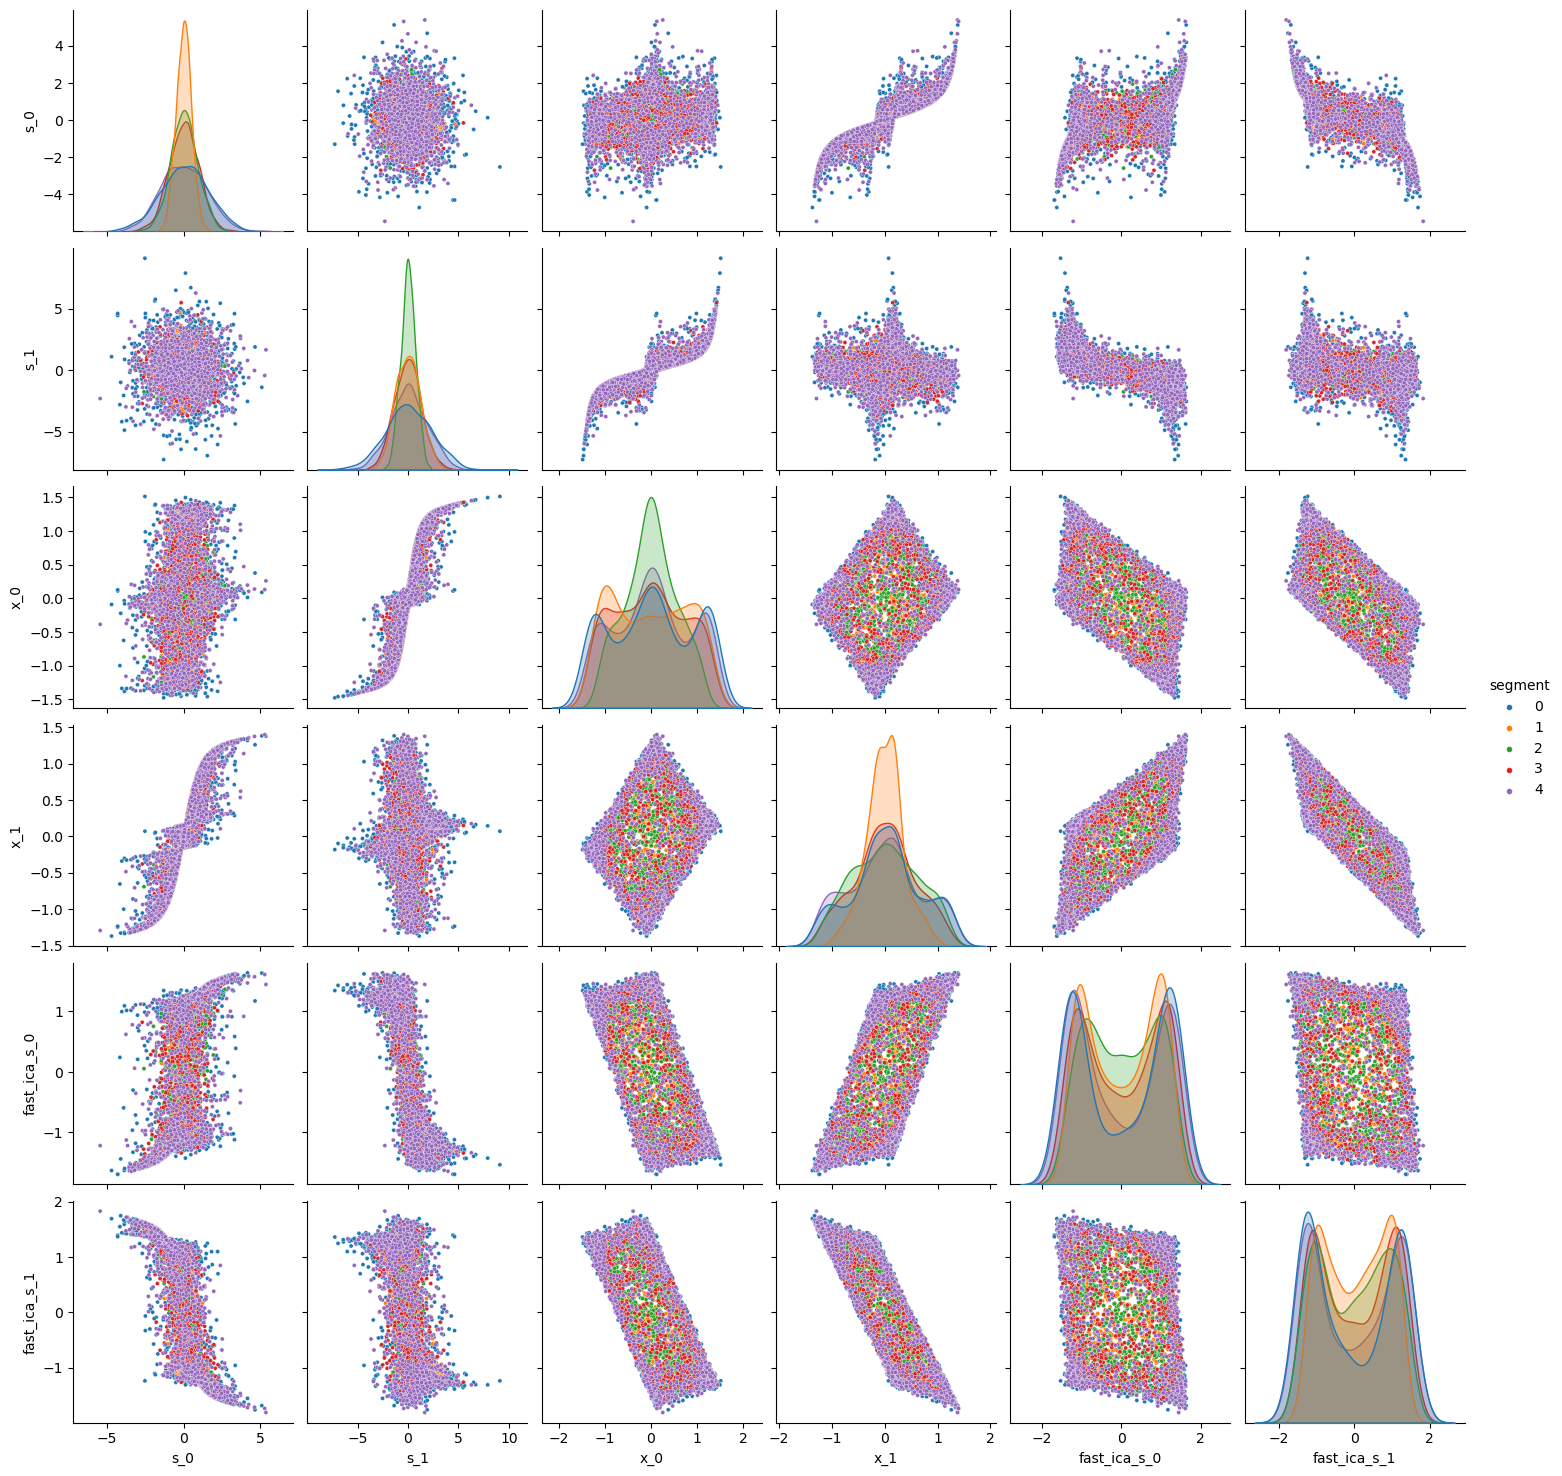

In [109]:
sns.pairplot(df_fast_ica, hue="segment", palette=f"tab10")

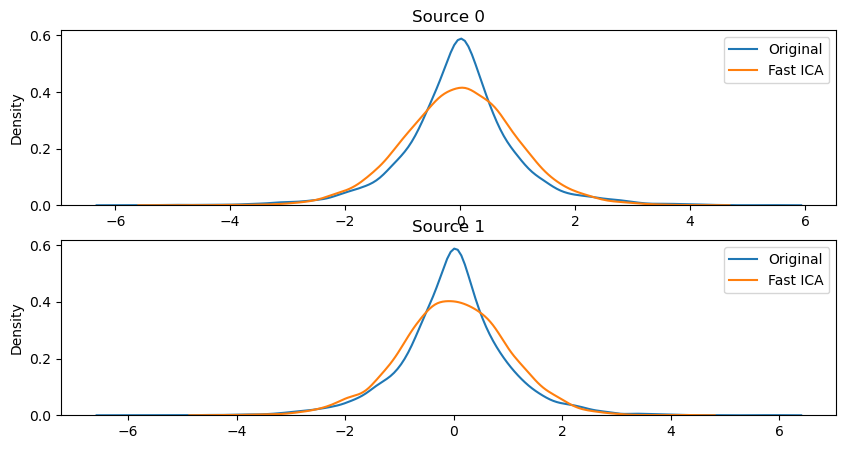

In [227]:
# plot distibution
fig, axs = plt.subplots(source.shape[1], 1, figsize=(10, 5))
for i in range(source.shape[1]):
    sns.kdeplot(source[:, i], ax=axs[i], label="Original")
    sns.kdeplot(fast_ica_source_predict[:, i], ax=axs[i], label="Fast ICA")
    axs[i].set_title(f"Source {i}")
    axs[i].legend()

In [125]:
mcc(source, fast_ica_source_predict)

0.970565942542888

## VAE

In [277]:
dataset = CustomSyntheticDataset(
    X=mixture,
    U=segment_labels,
    S=source,
    device=device
)

loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    **loader_params
)

data loaded on cpu


In [278]:
model = cleanVAE(
    data_dim=dimension_of_data_space,
    latent_dim=dimension_of_latent_space,
    hidden_dim=vae_hidden_dim,
    n_layers=vae_n_layers,
    activation=vae_activation,
    slope=vae_slope,
).to(device)

optimizer = Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=0, verbose=True
)

In [279]:
train_loss_hist = []
train_perf_hist = []
eval_perf_hist = []

# train model
itterable = tqdm(range(1, epochs+1))
for epoch in itterable:
    model.train()
    train_loss = 0
    train_perf = 0
    for batch in data_loader:
        x, u, s_true = batch
        x, s_true = x.to(device), s_true.to(device)
        optimizer.zero_grad()
        # u is not used here
        loss, s_predicted = model.elbo(x, u, len(dataset), a=a, b=b, c=c, d=d)
        loss.backward()
        train_loss += loss.item()
        perf = mcc(s_true.numpy(), s_predicted.cpu().detach().numpy())
        train_perf += perf
        optimizer.step()

    train_perf /= len(data_loader)
    train_perf_hist.append(train_perf)
    train_loss /= len(data_loader)
    train_loss_hist.append(train_loss)

    # Evaluate model
    _, _, _, s_eval = model(dataset.x.to(device))
    perf_all = mcc(dataset.s.numpy(), s_eval.cpu().detach().numpy())
    eval_perf_hist.append(perf_all)
    itterable.set_description(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.2f} | Train Perf: {train_perf:.2f} | Eval Perf: {perf_all:.2f}")


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 100/100 | Train Loss: -182.42 | Train Perf: 0.63 | Eval Perf: 0.65: 100%|██████████| 100/100 [00:17<00:00,  5.72it/s]


Text(0.5, 1.0, 'Eval perf')

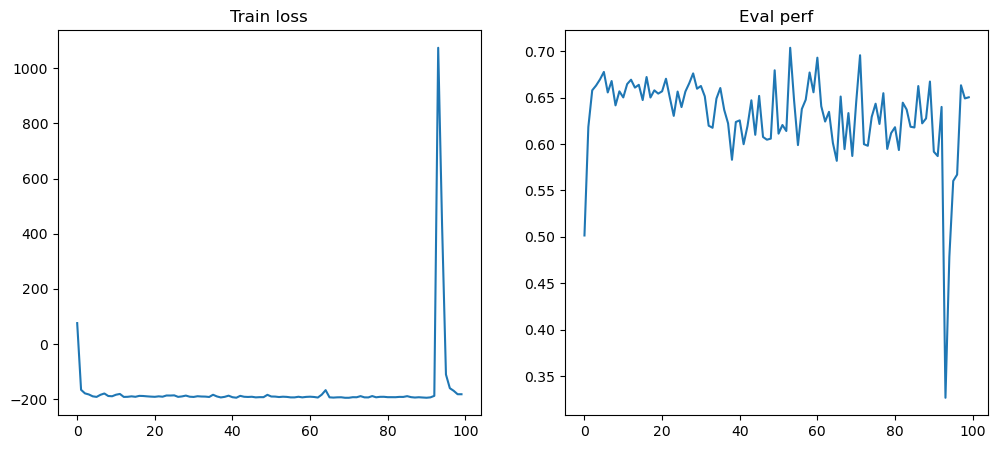

In [287]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax[0].plot(train_loss_hist)
ax[0].set_title("Train loss")
ax[1].plot(eval_perf_hist)
ax[1].set_title("Eval perf")

In [281]:
model.eval()
_, _, _, s_predicted = model(dataset.x.to(device))
s_predicted = s_predicted.cpu().detach().numpy()

In [282]:
vae_df = pd.concat([
    df,
    pd.DataFrame(s_predicted, columns=[f"vae_s_{i}" for i in range(s_predicted.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'VAE recovered sources')

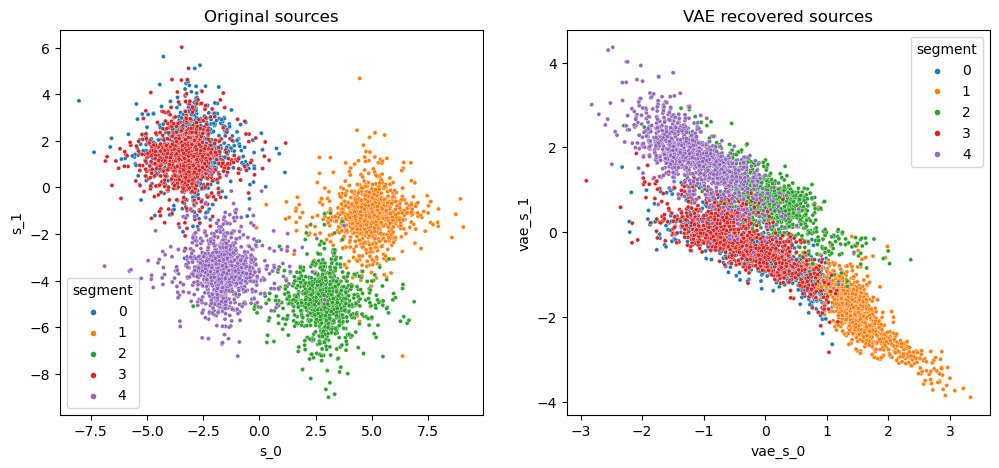

In [285]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
sns.scatterplot(data=vae_df, x="vae_s_0", y="vae_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("VAE recovered sources")

## IVAE

In [288]:
dataset = CustomSyntheticDataset(
    X=mixture,
    U=segment_labels,
    S=source,
    device=device
)

loader_params = (
    {"num_workers": 6, "pin_memory": True} if torch.cuda.is_available() else {}
)
data_loader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    **loader_params
)

data loaded on cpu


In [290]:
model = cleanIVAE(
    data_dim=dimension_of_data_space,
    latent_dim=dimension_of_latent_space,
    hidden_dim=vae_hidden_dim,
    aux_dim=number_of_segments,
    n_layers=vae_n_layers,
    activation=vae_activation,
    slope=vae_slope,
).to(device)

optimizer = Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.1, patience=0, verbose=True
)

In [291]:
train_loss_hist = []
train_perf_hist = []
eval_perf_hist = []

# train model
itterable = tqdm(range(1, epochs+1))
for epoch in itterable:
    model.train()
    train_loss = 0
    train_perf = 0
    for batch in data_loader:
        x, u, s_true = batch
        x, s_true = x.to(device), s_true.to(device)
        optimizer.zero_grad()
        # u is not used here
        loss, s_predicted = model.elbo(x, u, len(dataset), a=a, b=b, c=c, d=d)
        loss.backward()
        train_loss += loss.item()
        perf = mcc(s_true.numpy(), s_predicted.cpu().detach().numpy())
        train_perf += perf
        optimizer.step()

    train_perf /= len(data_loader)
    train_perf_hist.append(train_perf)
    train_loss /= len(data_loader)
    train_loss_hist.append(train_loss)

    # Evaluate model
    _, _, _, s_eval, _ = model(dataset.x.to(device), dataset.u.to(device))
    perf_all = mcc(dataset.s.numpy(), s_eval.cpu().detach().numpy())
    eval_perf_hist.append(perf_all)
    itterable.set_description(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.2f} | Train Perf: {train_perf:.2f} | Eval Perf: {perf_all:.2f}")


Epoch 100/100 | Train Loss: -197.61 | Train Perf: 0.63 | Eval Perf: 0.63: 100%|██████████| 100/100 [00:20<00:00,  4.78it/s]


Text(0.5, 1.0, 'Eval perf')

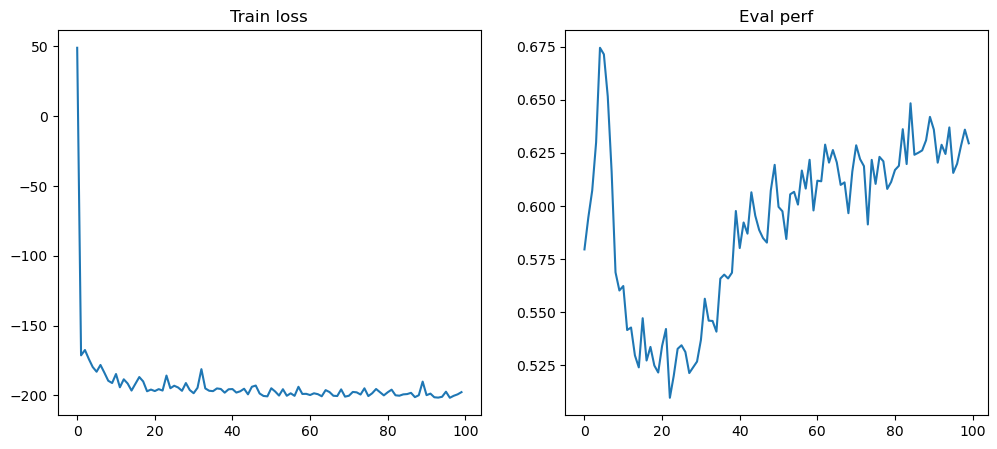

In [292]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
ax[0].plot(train_loss_hist)
ax[0].set_title("Train loss")
ax[1].plot(eval_perf_hist)
ax[1].set_title("Eval perf")

In [299]:
model.eval()
_, _, _, s_predicted, _ = model(dataset.x.to(device), dataset.u.to(device))
s_predicted = s_predicted.cpu().detach().numpy()

In [300]:
ivae_df = pd.concat([
    df,
    pd.DataFrame(s_predicted, columns=[f"ivae_s_{i}" for i in range(s_predicted.shape[1])]),
], axis=1)

Text(0.5, 1.0, 'iVAE recovered sources')

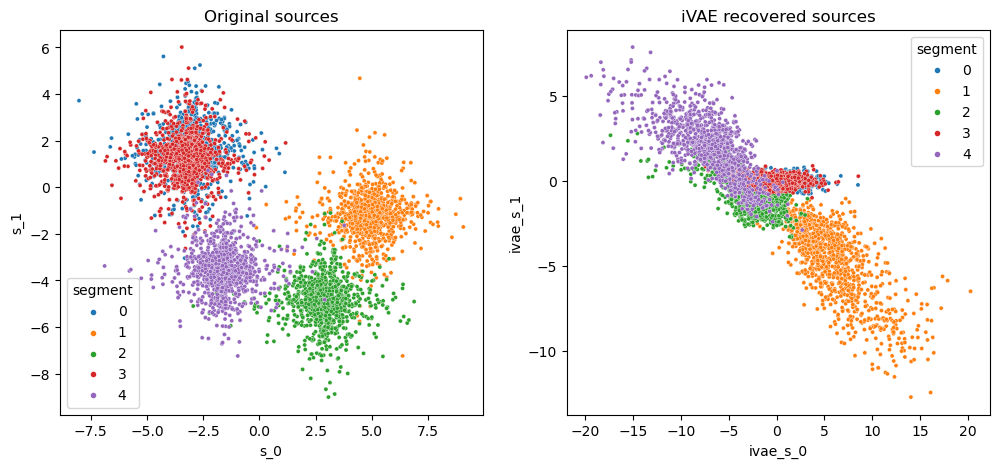

In [301]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 
sns.scatterplot(data=df, x="s_0", y="s_1", hue="segment", palette="tab10", ax=ax[0])
ax[0].set_title("Original sources")
sns.scatterplot(data=ivae_df, x="ivae_s_0", y="ivae_s_1", hue="segment", palette="tab10", ax=ax[1])
ax[1].set_title("iVAE recovered sources")